In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor

from gbi.GBI import GBInference
from gbi.distances import mse_dist, mae_dist
import gbi.hh.utils as utils
from sbi.utils import mcmc_transform
from sbi.inference import MCMCPosterior
from sbi.analysis import pairplot
from sbi.inference import SNPE

from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

/home/michael/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("data/theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("data/summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

In [4]:
nsims = 100_000

In [5]:
theta = theta[:nsims]
x = x[:nsims]

In [6]:
data_std = torch.std(x, dim=0)

In [7]:
def mae_dist_z(xs: Tensor, x_o: Tensor) -> Tensor:
    # Shape of xs should be [num_thetas, num_xs, num_x_dims].
    dist = (xs - x_o).abs()
    dist /= data_std
    mae = dist.mean(dim=2)  # Average over data dimensions.
    return mae.mean(dim=1)  # Monte-Carlo average

In [8]:
n_nonaug_x = nsims
n_augmented_x = nsims
noise_level = 1.0

In [9]:
x_aug = x[torch.randint(x.shape[0], size=(n_augmented_x,))]
x_aug = x_aug + torch.randn(x_aug.shape) * x.std(dim=0) * noise_level
x_target = torch.cat([x[:n_nonaug_x], x_aug])

In [10]:
true_params, labels_params = utils.obs_params(reduced_model=False)

prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)

In [11]:
inference = GBInference(prior, mae_dist_z, do_precompute_distances=False)
inference = inference.append_simulations(theta, x, x_target)
inference.initialize_distance_estimator(
    3, 
    50, 
    positive_constraint_fn="relu",
    net_kwargs={
        "z_score_theta": True,
        "z_score_x": True,
        "z_score_dists": True,
    }
)

In [12]:
distance_net = inference.train(
    training_batch_size=2_000,
    max_n_epochs=500,
    stop_after_counter_reaches=50,
    print_every_n=1,
    plot_losses=False,
)

0: train loss: 0.927617, val loss: 0.873905, 1.0199 seconds per epoch.
1: train loss: 0.137851, val loss: 0.139756, 0.8577 seconds per epoch.
2: train loss: 0.100115, val loss: 0.097565, 0.8444 seconds per epoch.
3: train loss: 0.085751, val loss: 0.086569, 0.8455 seconds per epoch.
4: train loss: 0.081508, val loss: 0.079952, 0.9250 seconds per epoch.
5: train loss: 0.077830, val loss: 0.076437, 0.7516 seconds per epoch.
6: train loss: 0.074970, val loss: 0.073549, 0.8436 seconds per epoch.
7: train loss: 0.065760, val loss: 0.071225, 0.9080 seconds per epoch.
8: train loss: 0.068864, val loss: 0.066084, 0.8163 seconds per epoch.
9: train loss: 0.061176, val loss: 0.063766, 0.8371 seconds per epoch.
10: train loss: 0.060344, val loss: 0.061309, 0.8529 seconds per epoch.
11: train loss: 0.058328, val loss: 0.060618, 0.9552 seconds per epoch.
12: train loss: 0.059015, val loss: 0.059898, 0.8486 seconds per epoch.
13: train loss: 0.055182, val loss: 0.056762, 0.8500 seconds per epoch.
14

In [13]:
inds1 = torch.randint(0, 1000, (100,))
inds2 = torch.randint(0, 1000, (100,))
pred_dists = distance_net.forward(theta[inds1], x_target[inds2]).detach()
true_dists = torch.mean(torch.abs(x[inds1] - x_target[inds2]) / data_std, dim=1)

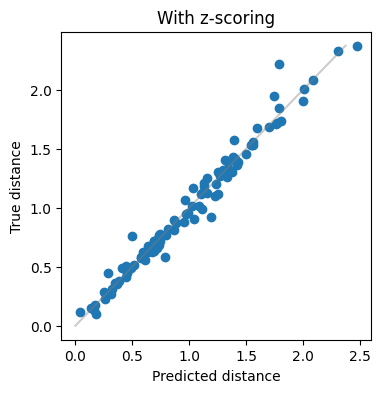

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_ = ax.scatter(pred_dists.numpy(), true_dists.numpy())
_ = ax.plot([0, np.max(true_dists.numpy())], [0, np.max(true_dists.numpy())], c="grey", alpha=0.4)
_ = ax.set_xlabel("Predicted distance")
_ = ax.set_ylabel("True distance")
_ = ax.set_title("With z-scoring")

### Run NPE

In [117]:
npe = SNPE(prior=prior, density_estimator="nsf")

In [118]:
_ = npe.append_simulations(theta[:10000], x[:10000]).train(training_batch_size=500)

 Neural network successfully converged after 337 epochs.

In [120]:
posterior_npe = npe.build_posterior().set_default_x(xo)
npe_samples = posterior_npe.sample((1000,))

Drawing 1000 posterior samples: 1100it [00:00, 24690.73it/s]                                                                            


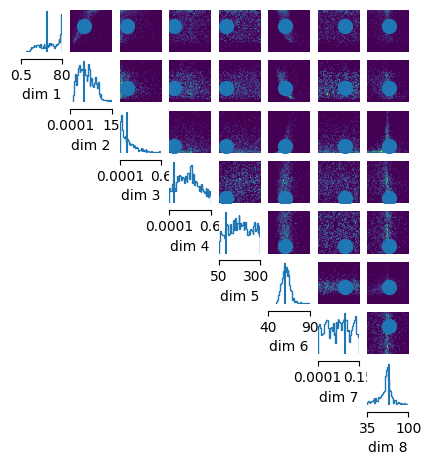

In [121]:
_ = pairplot(npe_samples, limits=limits, points=gt, ticks=limits, figsize=(5, 5))

In [122]:
r = [sim.gen_single(theta, seed=0) for theta in npe_samples[:10]]

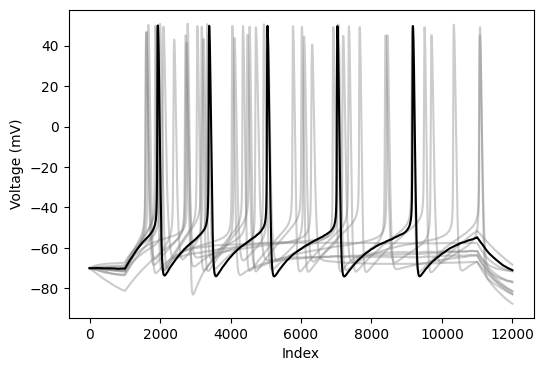

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for resp in r:
    _ = ax.plot(resp["data"], c="grey", alpha=0.4)
_ = ax.plot(obs["data"], c="k")
_ = ax.set_xlabel("Index")
_ = ax.set_ylabel("Voltage (mV)")

### Eval

In [15]:
# with open("inference_100k.pkl", "wb") as handle:
#     pickle.dump(inference, handle)

In [36]:
beta = 200.0

In [37]:
with open("data/xo.pkl", "rb") as handle:
    xo = pickle.load(handle)

gt = torch.as_tensor(true_params)

In [38]:
potential_fn = inference.get_potential(x_o=xo, beta=beta)
theta_transform = mcmc_transform(prior)

In [39]:
posterior = MCMCPosterior(
    potential_fn,
    theta_transform=theta_transform,
    proposal=prior,
    method="slice_np_vectorized",
    thin=10,
    warmup_steps=100,
    num_chains=100,
    init_strategy="resample",
    frac_chains_to_finish=0.9,
)

In [40]:
posterior_samples = posterior.sample((1_000,), frac_chains_to_finish=0.9)

Running vectorized MCMC with 100 chains: 100%|████████████████████████████████████████████████▊| 110700/111200 [02:18<00:00, 798.57it/s]


In [41]:
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T

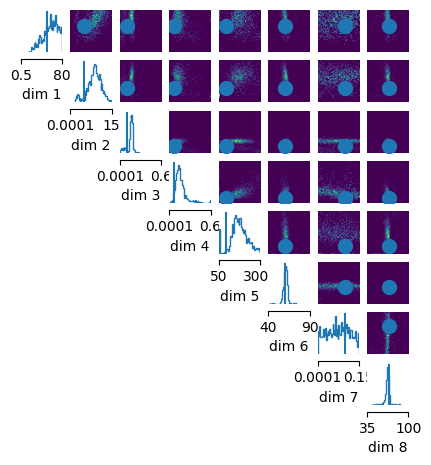

In [42]:
_ = pairplot(posterior_samples, limits=limits, points=gt, ticks=limits, figsize=(5, 5))

### Posterior predictives

In [43]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [44]:
I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=seed, cython=True)

In [45]:
sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

In [46]:
r = [sim.gen_single(theta, seed=0) for theta in posterior_samples[:10]]

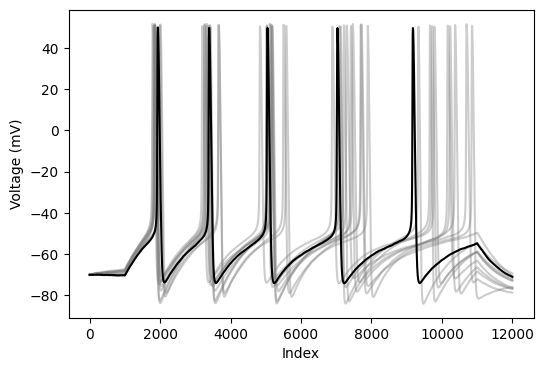

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for resp in r:
    _ = ax.plot(resp["data"], c="grey", alpha=0.4)
_ = ax.plot(obs["data"], c="k")
_ = ax.set_xlabel("Index")
_ = ax.set_ylabel("Voltage (mV)")
plt.savefig("hh_predictives.png", dpi=200, bbox_inches="tight")